In [106]:
# imports
import numpy as np
import pandas as pd
import seaborn as sns
import pandas_datareader as dr
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.gridspec as gridspec
import yfinance as yf

from collections import OrderedDict
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import adfuller, kpss, bds
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox, acorr_breusch_godfrey
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import skewtest, kurtosistest, skew, kurtosis, boxcox
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import numpy as np

from sklearn.neural_network import MLPRegressor


In [107]:
df = pd.read_csv("dataset/filtered_data_2.csv")
df.set_index('Data e Hora', drop=True, inplace=True)
df.index = pd.to_datetime(df.index)
fittedValsToShow = 50
previousStepsToShow=100
seasonal_periods= 365

## Define functions
    Defines helper functions

In [108]:
def create_lagged_features(series, n_lags=5):
    df = pd.DataFrame({'y': series})
    for i in range(1, n_lags + 1):
        df[f'lag_{i}'] = df['y'].shift(i)
    df.dropna(inplace=True)
    return df


In [109]:
def train_and_evaluate_svr(df_train, df_test, n_lags=5, test_split_ratio=0.8, kernel='rbf', C=100, gamma=0.01, epsilon=0.01):
    """
    Train and evaluate an SVR model on lagged features of the residual series.

    Parameters:
        df_train (pd.Series): Training series.
        df_test (pd.Series): Testing series.
        n_lags (int): Number of lagged features to create.
        test_split_ratio (float): Ratio for train-test split.
        kernel (str): Kernel type for SVR.
        C (float): Regularization parameter for SVR.
        gamma (float): Kernel coefficient for SVR.
        epsilon (float): Epsilon in the epsilon-SVR model.

    Returns:
        np.ndarray: Forecasted residuals for the test set.
    """
    # Create lagged feature dataframe
    df_lagged = create_lagged_features(pd.concat([df_train, df_test]), n_lags=n_lags)

    # Train-test split (time-aware)
    split = int(len(df_lagged) * test_split_ratio)
    train_df = df_lagged.iloc[:split]
    test_df = df_lagged.iloc[split:]

    X_train = train_df.drop(columns='y').values
    y_train = train_df['y'].values
    X_test = test_df.drop(columns='y').values
    y_test = test_df['y'].values

    # Scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train SVR
    svm_model = SVR(kernel=kernel, C=C, gamma=gamma, epsilon=epsilon)
    svm_model.fit(X_train_scaled, y_train)

    # Predict
    y_pred = svm_model.predict(X_test_scaled)

    # Evaluate
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"R-squared: {r2:.4f}")
    # Calculate Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(y_test, label='Actual Residuals', linewidth=2)
    plt.plot(y_pred, label='Predicted Residuals (SVR)', linestyle='--')
    plt.title('SVR Residual Prediction')
    plt.xlabel('Time Step')
    plt.ylabel('Residual Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return y_pred


In [ ]:
def train_and_plot_exponential_smoothing_Trend(df_train, df_test, fitted_vals_to_show,steps_to_forecast):
    """
    Train and plot an Exponential Smoothing model with additive damped trend.

    Parameters:
        df_train (pd.Series or np.ndarray): Training data.
        df_test (pd.Series or np.ndarray): Testing data.
        fitted_vals_to_show (int): Number of fitted values to show in the plot.

    Returns:
        tuple: (model, forecast, success_flag)
    """
    try:
        # Initialize the model
        model = ExponentialSmoothing(df_train.values, 
                                      trend='multiplicative', 
                                      damped=False,
                                      seasonal=None)
        # Fit the model
        fitted_model = model.fit(smoothing_level=None, 
                                 smoothing_slope=None, 
                                 damping_slope=None)

        # Check if optimization was successful
        if fitted_model.mle_retvals.success:
            forecast = fitted_model.forecast(steps_to_forecast)

            # Check for NaN values in the forecast
            if not np.isnan(forecast).any():
                title = 'TS (Ad,N) - Additive damped trend method with ' \
                    + r'$\alpha$' + ' = ' + str(round(fitted_model.params['smoothing_level'], 2))

                if 'smoothing_slope' in fitted_model.params:
                    title += r', $\beta$' + ' = ' + str(round(fitted_model.params['smoothing_slope'], 2))

                if 'damping_slope' in fitted_model.params:
                    title += r', $\zeta$' + ' = ' + str(round(fitted_model.params['damping_slope'], 2))

                print("Trend forecasting successful!")
                # Plot the trend forecast
                plt.figure(figsize=(12, 6))
                plt.plot(df_test.index[:steps_to_forecast], forecast[:steps_to_forecast], 'r--', label='Trend Forecast', linewidth=2)
                plt.plot(df_test.index[:steps_to_forecast], df_test[:steps_to_forecast], 'b-', label='Actual Trend', linewidth=1)
                plt.title('Trend Component Forecast', fontsize=14)
                plt.xlabel('Date')
                plt.ylabel('Trend Value')
                plt.legend()
                plt.grid(True)
                plt.tight_layout()
                plt.show()
                # Calculate R-squared
                actual_test_data_aligned = df_test.iloc[:len(forecast)]
                ss_total = np.sum((actual_test_data_aligned - actual_test_data_aligned.mean())**2)
                ss_residual = np.sum((actual_test_data_aligned - forecast)**2)
                r_squared = 1 - (ss_residual / ss_total)
                print(f"R-squared: {r_squared:.4f}")
                # Calculate Mean Absolute Error Percentage (MAEP)
                maep = np.mean(np.abs((actual_test_data_aligned - forecast) / actual_test_data_aligned)) * 100
                print(f"Mean Absolute Error Percentage (MAEP): {maep:.2f}%")

                # Calculate Mean Squared Error (MSQ)
                msq = np.mean((actual_test_data_aligned - forecast) ** 2)
                print(f"Mean Squared Error (MSQ): {msq:.4f}")
                return fitted_model, forecast, True
            else:
                print('RuntimeWarning: invalid value encountered in forecast.')
                return fitted_model, None, False
        else:
            print('ConvergenceWarning: Optimization failed to converge.')
            return None, None, False
    except Exception as e:
        print(f"Error: {e}")
        return None, None, False

In [111]:
def train_and_plot_exponential_smoothing_Seasonality(df_train, df_test, seasonal_periods,steps_to_forecast):
    """
    Train and plot an Exponential Smoothing model with multiplicative seasonality.

    Parameters:
        df_train (pd.Series or np.ndarray): Training data.
        df_test (pd.Series or np.ndarray): Testing data.
        seasonal_periods (int): Seasonal period for the model.

    Returns:
        tuple: (model, forecast, success_flag)
    """
    try:
        # Initialize the model
        model = ExponentialSmoothing(df_train.values, 
                                      trend=None, 
                                      damped=False, 
                                      seasonal='mul', 
                                      seasonal_periods=seasonal_periods)
        # Fit the model
        fitted_model = model.fit(smoothing_level=None, 
                                 smoothing_seasonal=None)

        # Check if optimization was successful
        if fitted_model.mle_retvals.success:
            forecast = fitted_model.forecast(steps_to_forecast)

            # Check for NaN values in the forecast
            if not np.isnan(forecast).any():
                title = 'TS (N, M) with ' \
                    + r'$\alpha$' + ' = ' + str(round(fitted_model.params['smoothing_level'], 2)) \
                    + r', $\gamma$' + ' = ' + str(round(fitted_model.params['smoothing_seasonal'], 2)) \
                    + ', m = ' + str(model.seasonal_periods)

                # Plot the results
                print("Seasonal forecasting successful!")
                # Plot the seasonal forecast
                plt.figure(figsize=(12, 6))
                plt.plot(df_test.index[:steps_to_forecast], forecast, 'r--', label='Seasonal Forecast', linewidth=2)
                plt.plot(df_test.index[:steps_to_forecast], df_test[:steps_to_forecast], 'b-', label='Actual Seasonality', linewidth=1)
                plt.title('Seasonal Component Forecast', fontsize=14)
                plt.xlabel('Date')
                plt.ylabel('Seasonal Value')
                plt.legend()
                plt.grid(True)
                plt.tight_layout()
                plt.show()
                # Calculate R-squared
                actual_test_data_aligned = df_test.iloc[:len(forecast)]
                ss_total = np.sum((actual_test_data_aligned - actual_test_data_aligned.mean())**2)
                ss_residual = np.sum((actual_test_data_aligned - forecast)**2)
                r_squared = 1 - (ss_residual / ss_total)
                print(f"R-squared: {r_squared:.4f}")


                return fitted_model, forecast, True
            else:
                print('RuntimeWarning: invalid value encountered in forecast.')
                return fitted_model, None, False
        else:
            print('ConvergenceWarning: Optimization failed to converge.')
            return None, None, False
    except Exception as e:
        print(f"Error: {e}")
        return None, None, False

In [112]:
def train_and_forecast_mlp(df_train, df_test, n_lags=5, title=None):

    # Create lagged feature dataframe
    test_split_ratio = 0.8
    if(title=="MLP Trend Forecast"):
        hidden_layer_sizes = (15,15)
    else:
        hidden_layer_sizes = (50,25)   
    activation = 'relu'
    solver = 'adam'
    max_iter = 1000
    random_state = 42
    df_lagged = create_lagged_features(pd.concat([df_train, df_test]), n_lags=n_lags)

    # Train-test split (time-aware)
    split = int(len(df_lagged) * test_split_ratio)
    train_df = df_lagged.iloc[:split]
    test_df = df_lagged.iloc[split:]

    X_train = train_df.drop('y', axis=1).values
    y_train = train_df['y'].values
    X_test = test_df.drop('y', axis=1).values
    y_test = test_df['y'].values

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train MLP Regressor
    mlp_model = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, activation=activation,
                             solver=solver, max_iter=max_iter, random_state=random_state)
    mlp_model.fit(X_train_scaled, y_train)

    # Print MLP model summary
    print(f"MLP Regressor Summary:")
    print(f"Hidden Layer Sizes: {mlp_model.hidden_layer_sizes}")
    print(f"Activation Function: {mlp_model.activation}")
    print(f"Solver: {mlp_model.solver}")
    print(f"Max Iterations: {mlp_model.max_iter}")
    print(f"Random State: {mlp_model.random_state}")
    print(f"Number of Iterations: {mlp_model.n_iter_}")
    print(f"Loss: {mlp_model.loss_}")

    # Predict
    y_pred = mlp_model.predict(X_test_scaled)

    # Evaluate
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"MLP Mean Squared Error: {mse:.4f}")
    print(f"MLP R-squared: {r2:.4f}")
    # Calculate Mean Absolute Error Percentage (MAEP)
    maep = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    print(f"MLP Mean Absolute Error Percentage (MAEP): {maep:.2f}%")
    # Plot
    dates = test_df.index
    plt.figure(figsize=(12, 6))
    plt.plot(dates, y_test, label='Actual data', linewidth=2)
    plt.plot(dates, y_pred, label='Predicted values (MLP)', linestyle='--')
    plt.title(title if title else 'MLP Prediction')
    plt.xlabel('Date')
    plt.ylabel(title +'Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return y_pred


## Dataset

#### Nota 
- Nota: Aplicando uma escala logarítmica aos dados, pode transformar um modelo multiplicativo num aditivo
#### Tipo de modelo que esperamos:
- 'additive' - A amplitude do efeito sazonal mantém-se constante todos os anos
- 'multiplicative' - Os efeitos sazonais e outros atuam proporcionalmente sobre a série

- producao_renovavel é a agregação das colunas hidrica, eolica, solar, ondas, biomassa
- producao_nao_renovavel é a agregação das colunas carvao, gas_natural, termica, producao_por_bombagem


In [113]:
Renoable_column = ['producao_renovavel','hidrica' ,'biomassa','eolica','solar','ondas']
NoneRenoable_column = ['producao_nao_renovavel','termica' ,'gas_natural','carvao','producao_por_bombagem']
Export_import_column = ['exportacao','importacao'] 

In [114]:
df_renewable = df['producao_renovavel']
df_non_renewable = df['producao_nao_renovavel']

<Figure size 1400x1000 with 0 Axes>

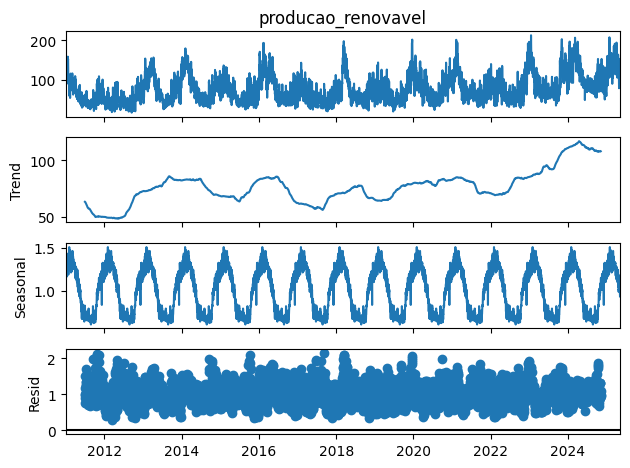

First index of the trend: 2011-07-02 00:00:00
Last index of the trend: 2024-11-06 00:00:00
Original data length: 5241
Trend component length: 4877
Seasonal component length: 4877
Residual component length: 4877


In [115]:
# Time Series Decomposition into Components with Consistent Naming

# First, perform the decomposition for non-renewable energy
decomposition_renewable = seasonal_decompose(df_renewable, model='multiplicative', period=seasonal_periods)

# Plot full decomposition
plt.figure(figsize=(14, 10))
decomposition_renewable.plot()
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

# Extract the components with consistent naming
# Remove values before the first trend index
trend_component = decomposition_renewable.trend.dropna().rename("trend")
first_trend_index = trend_component.index[0]
print(f"First index of the trend: {first_trend_index}")

# Align seasonal and residual components with the trend component
seasonal_component = decomposition_renewable.seasonal[first_trend_index:].rename("seasonal")
residual_component = decomposition_renewable.resid[first_trend_index:].rename("residual")

# Fixate the last value index of the trend component
last_trend_index = trend_component.index[-1]
print(f"Last index of the trend: {last_trend_index}")
seasonal_component = seasonal_component[:last_trend_index].rename("seasonal")
residual_component = residual_component[:last_trend_index].rename("residual")



print(f"Original data length: {len(df_renewable)}")
print(f"Trend component length: {len(trend_component)}")
print(f"Seasonal component length: {len(seasonal_component)}")
print(f"Residual component length: {len(residual_component)}")

In [116]:
# Split each component into training and testing sets
split_ratio = 0.8
split_index = int(len(trend_component) * split_ratio)


trend_train, trend_test = trend_component[:split_index], trend_component[split_index:]
seasonal_train, seasonal_test = seasonal_component[:split_index], seasonal_component[split_index:]
residual_train, residual_test = residual_component[:split_index], residual_component[split_index:]

print(f"Trend training set: {len(trend_train)} samples")
print(f"Trend testing set: {len(trend_test)} samples")


print(f"Seasonal training set: {len(seasonal_train)} samples")
print(f"Seasonal testing set: {len(seasonal_test)} samples")


print(f"Residual training set: {len(residual_train)} samples")
print(f"Residual testing set: {len(residual_test)} samples")

Trend training set: 3901 samples
Trend testing set: 976 samples
Seasonal training set: 3901 samples
Seasonal testing set: 976 samples
Residual training set: 3901 samples
Residual testing set: 976 samples


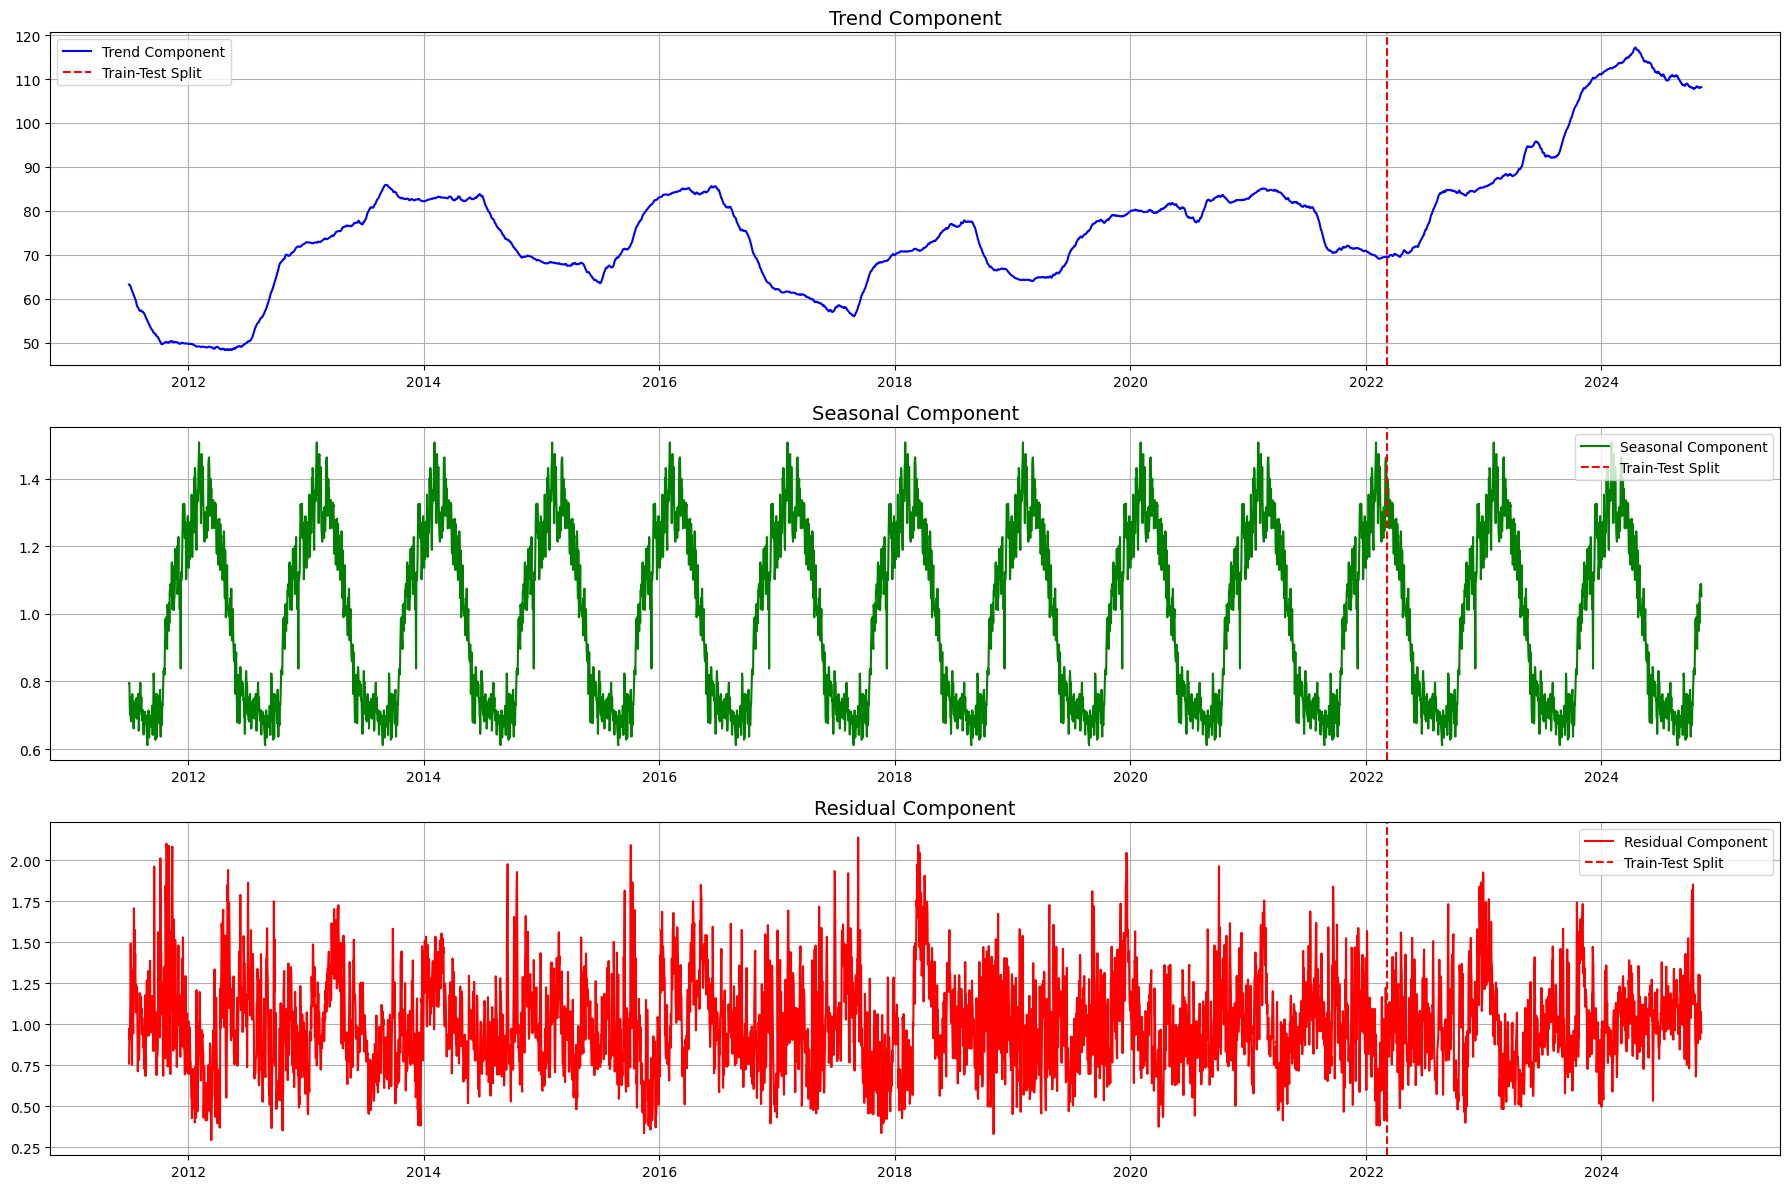

In [117]:

plt.figure(figsize=(18, 12))

# Plot trend
plt.subplot(3, 1, 1)
plt.plot(trend_component, 'b-', label='Trend Component')
plt.axvline(x=trend_component.index[split_index], color='r', linestyle='--', label='Train-Test Split')
plt.title('Trend Component', fontsize=14)
plt.legend()
plt.grid(True)

# Plot seasonality
plt.subplot(3, 1, 2)
plt.plot(seasonal_component, 'g-', label='Seasonal Component')
plt.axvline(x=seasonal_component.index[split_index], color='r', linestyle='--', label='Train-Test Split')
plt.title('Seasonal Component', fontsize=14)
plt.legend()
plt.grid(True)

# Plot residuals
plt.subplot(3, 1, 3)
plt.plot(residual_component, 'r-', label='Residual Component')
plt.axvline(x=residual_component.index[split_index], color='r', linestyle='--', label='Train-Test Split')
plt.title('Residual Component', fontsize=14)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

##  Prediction


In [118]:
steps_to_forecast = 900


Predicting residuals using MLP Regressor...
MLP Regressor Summary:
Hidden Layer Sizes: (15, 15)
Activation Function: relu
Solver: adam
Max Iterations: 1000
Random State: 42
Number of Iterations: 307
Loss: 0.007439810266204064
MLP Mean Squared Error: 0.1172
MLP R-squared: 0.9995
MLP Mean Absolute Error Percentage (MAEP): 0.25%


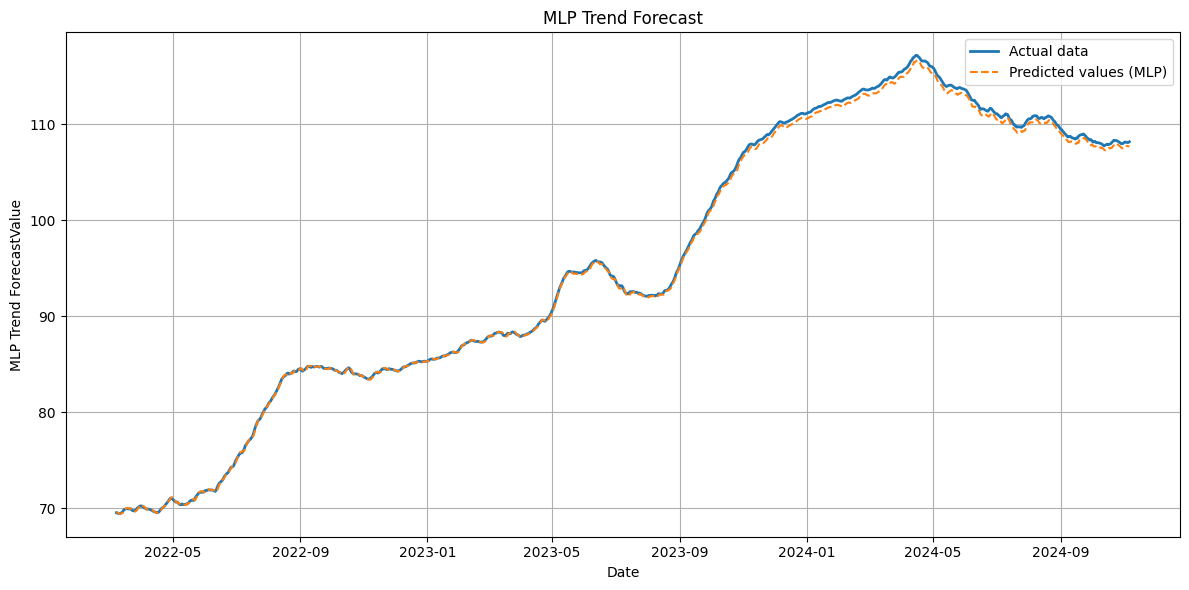

In [119]:

print("\nPredicting residuals using MLP Regressor...")

# Call the function to train and forecast residuals
trend_forecast_mlp = train_and_forecast_mlp(
    trend_train,
    trend_test,
    title='MLP Trend Forecast'
)



In [120]:

print("\nModeling se component with Exponential Smoothing (aditive trend)...")
trend_model, trend_forecast_Ets, trend_success = train_and_plot_exponential_smoothing_Trend(
    trend_train, 
    trend_test,
    50,
    steps_to_forecast
)




Modeling se component with Exponential Smoothing (aditive trend)...
Error: If not None, trend must be one of: 'add', 'mul', 'additive', 'multiplicative'



Modeling seasonal component with Exponential Smoothing (multiplicative seasonality)...
Seasonal forecasting successful!


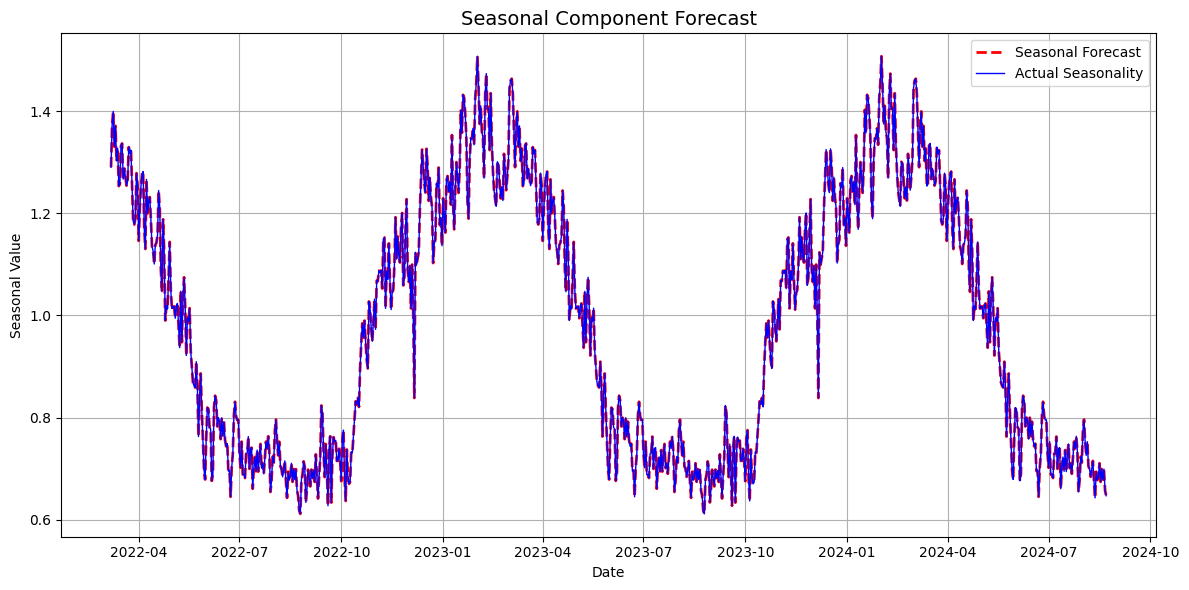

R-squared: 1.0000


In [121]:
print("\nModeling seasonal component with Exponential Smoothing (multiplicative seasonality)...")
seasonal_model, seasonal_forecast, seasonal_success = train_and_plot_exponential_smoothing_Seasonality(
    seasonal_train, 
    seasonal_test,
    seasonal_periods,
    steps_to_forecast
)


Modeling residual component with MLP Regressor...
MLP Regressor Summary:
Hidden Layer Sizes: (50, 25)
Activation Function: relu
Solver: adam
Max Iterations: 1000
Random State: 42
Number of Iterations: 31
Loss: 0.021097093958249425
MLP Mean Squared Error: 0.0310
MLP R-squared: 0.5285
MLP Mean Absolute Error Percentage (MAEP): 14.39%


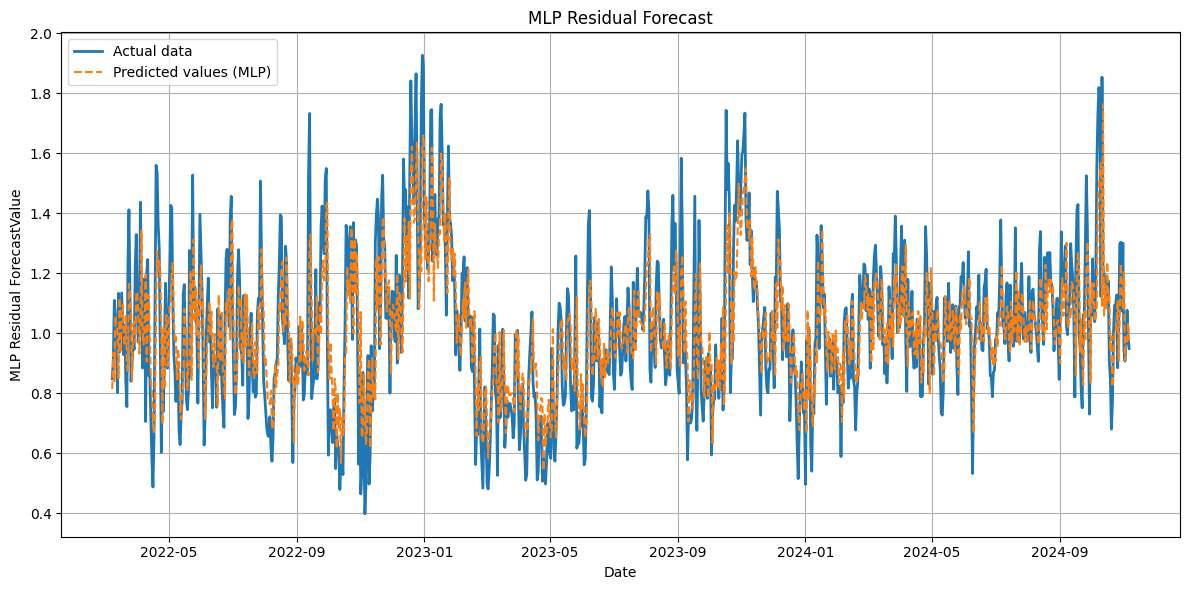

In [122]:
print("\nModeling residual component with MLP Regressor...")
# Define n_lags based on the properties of your data
n_lags = 5  # One week of lags
# Use the MLP model for residuals
residual_forecast_mlp = train_and_forecast_mlp(
    residual_train,
    residual_test,
    n_lags,
    title='MLP Residual Forecast'
)



Modeling residual component with Support Vector Regression...
Mean Squared Error: 0.0300
R-squared: 0.5437
Mean Absolute Percentage Error (MAPE): 13.76%


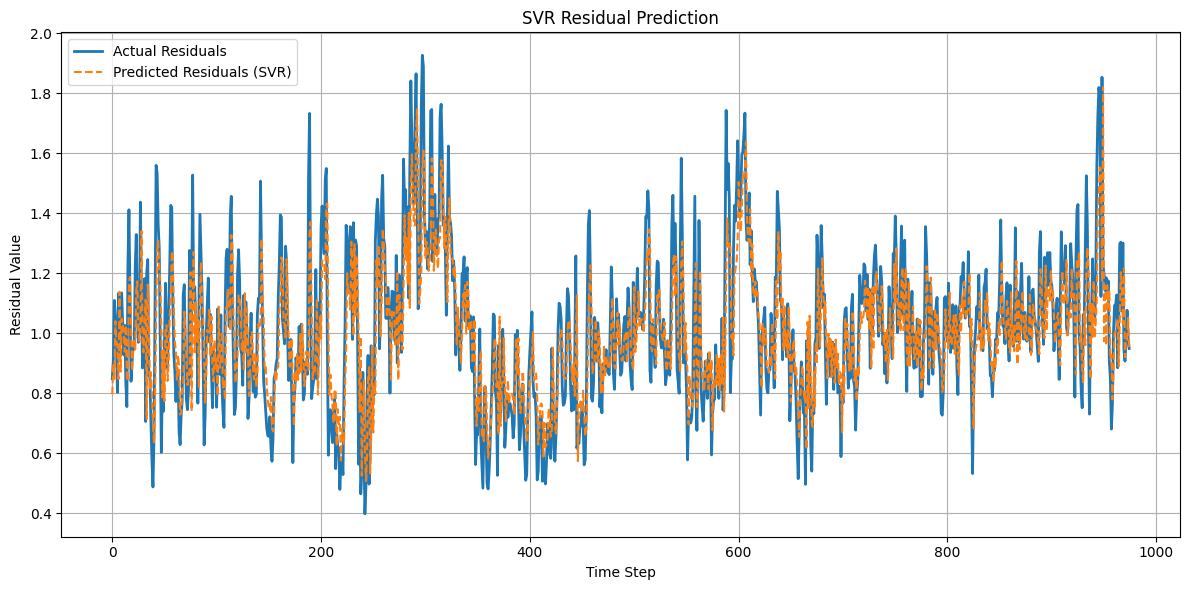

In [123]:
print("\nModeling residual component with Support Vector Regression...")
# Define n_lags based on the properties of your data
n_lags = 5 # One week of lags
# Use the SVR model for residuals
residual_forecast_SVR = train_and_evaluate_svr(
    residual_train,
    residual_test,
    n_lags
)


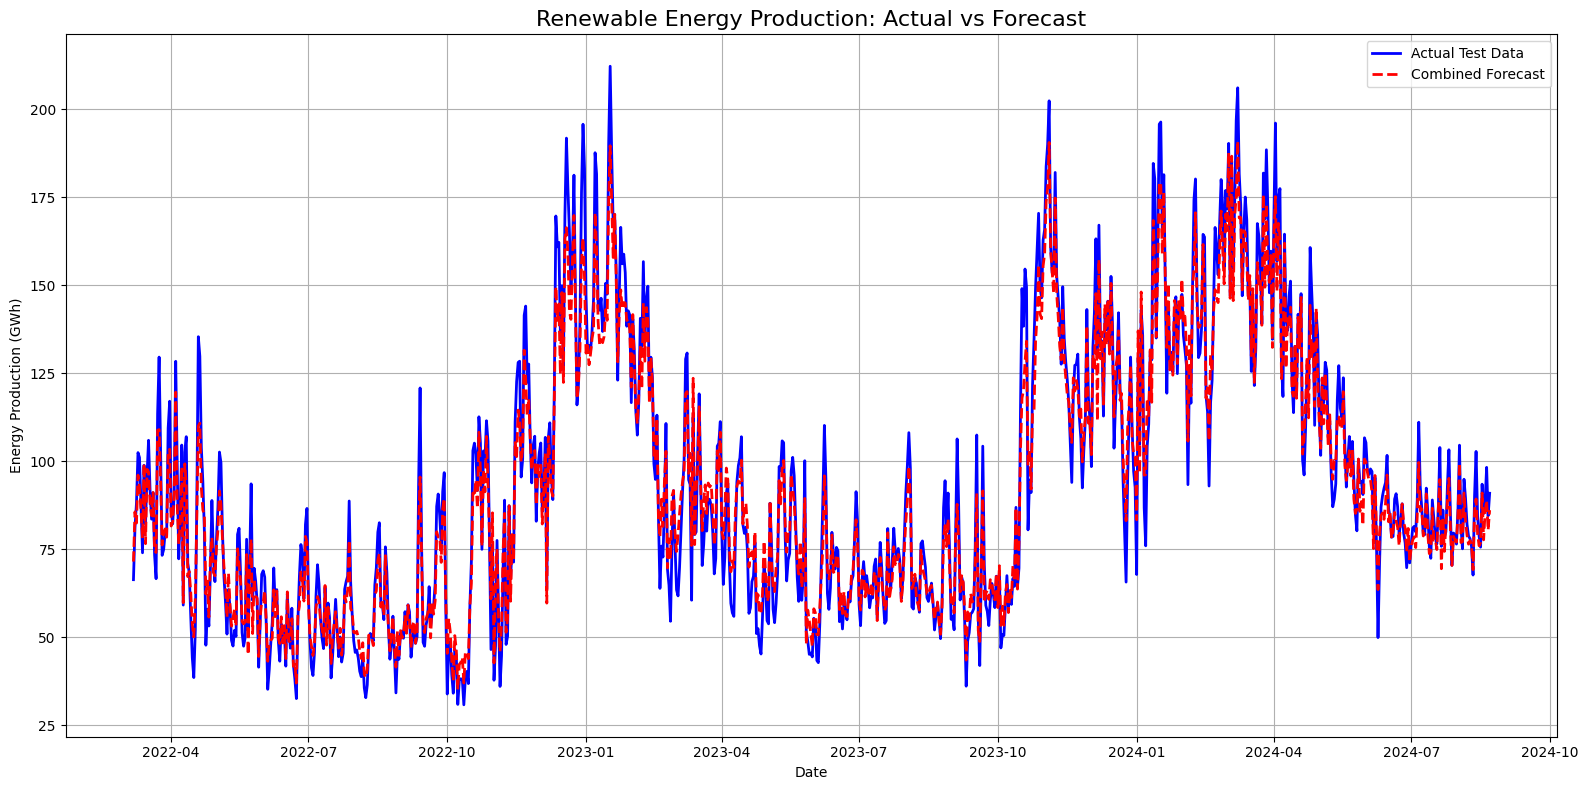


Forecast Accuracy Metrics:
MSE: 60.5660
RMSE: 7.7824
MAE: 5.8680
MAPE: 6.68%
R-squared: 0.9602


In [124]:
# Ensure indices align between actual test data and forecast
forecast_dates = trend_test.index[:steps_to_forecast]
combined_forecast = np.zeros(steps_to_forecast)
actual_test_data = df_renewable.loc[forecast_dates]

for i in range(steps_to_forecast):
    if i < len(trend_forecast_mlp) and i < len(seasonal_forecast) and i < len(residual_forecast_SVR):
        
        combined_forecast[i] = trend_forecast_mlp[i] * seasonal_forecast[i] *  residual_forecast_SVR[i]

# Create a pandas Series with the forecast
final_forecast = pd.Series(combined_forecast, index=forecast_dates)




# Plot the results
plt.figure(figsize=(16, 8))
plt.plot(actual_test_data, 'b-', label='Actual Test Data', linewidth=2)
plt.plot(final_forecast, 'r--', label='Combined Forecast', linewidth=2)
plt.title('Renewable Energy Production: Actual vs Forecast', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Energy Production (GWh)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate forecast accuracy metrics
# Align the lengths of actual_test_data and final_forecast
actual_test_data_aligned = actual_test_data.iloc[:len(final_forecast)]
mse = mean_squared_error(actual_test_data_aligned, final_forecast)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(actual_test_data - final_forecast))

# Avoid division by zero in MAPE calculation
if (actual_test_data == 0).any():
    print("Warning: Division by zero encountered in MAPE calculation.")
    mape = np.nan
else:
    mape = np.mean(np.abs((actual_test_data - final_forecast) / actual_test_data)) * 100

print(f"\nForecast Accuracy Metrics:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
# Calculate R-squared
ss_total = np.sum((actual_test_data_aligned - actual_test_data_aligned.mean())**2)
ss_residual = np.sum((actual_test_data_aligned - final_forecast)**2)
r_squared = 1 - (ss_residual / ss_total)

print(f"R-squared: {r_squared:.4f}")

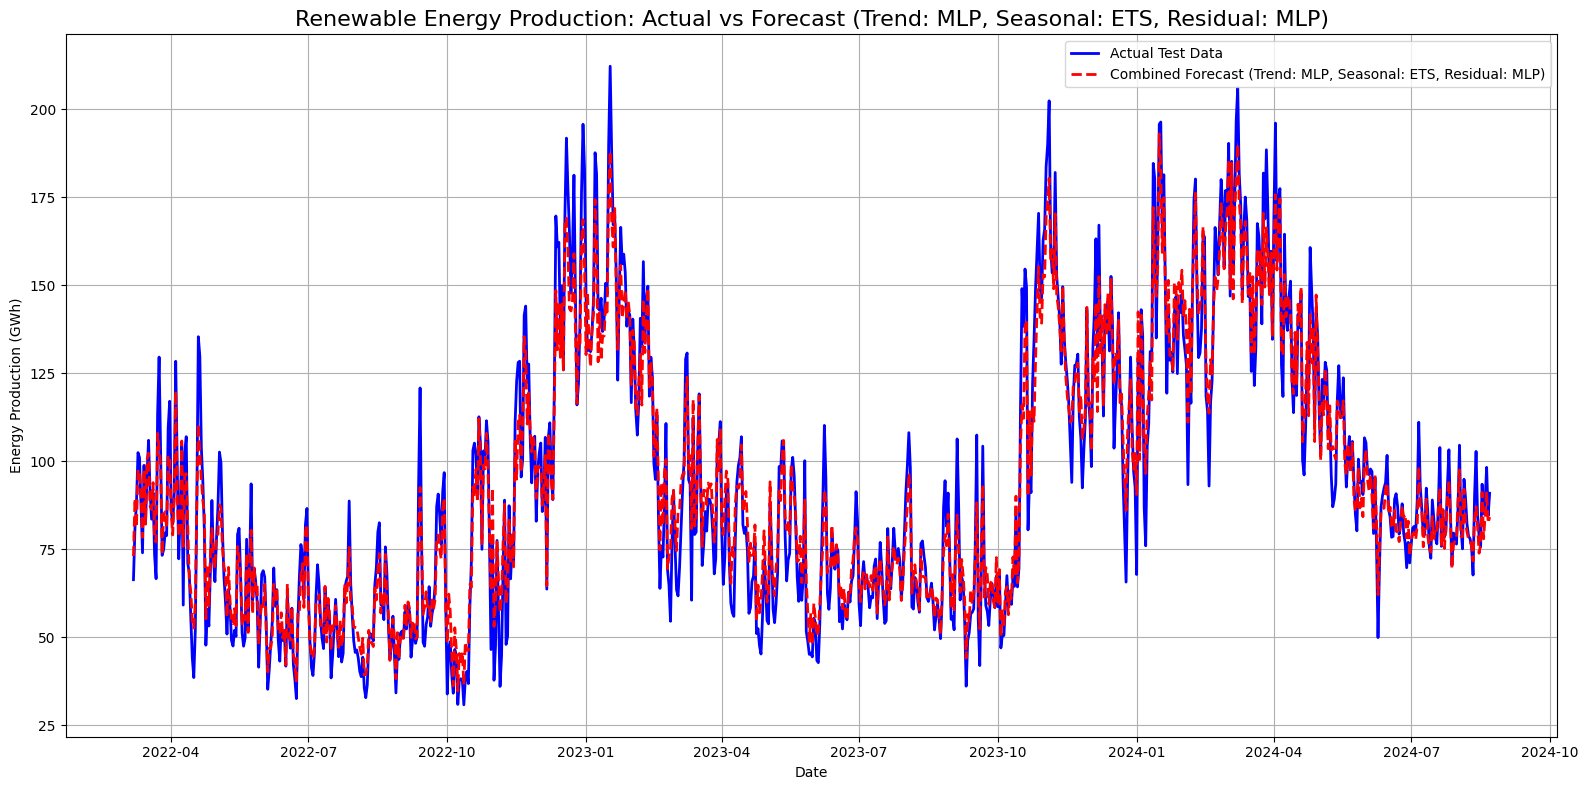


Forecast Accuracy Metrics for Trend: MLP, Seasonal: ETS, Residual: MLP:
MSE: 72.5245
RMSE: 8.5161
MAE: 6.4105
MAPE: 7.55%
R-squared: 0.9523


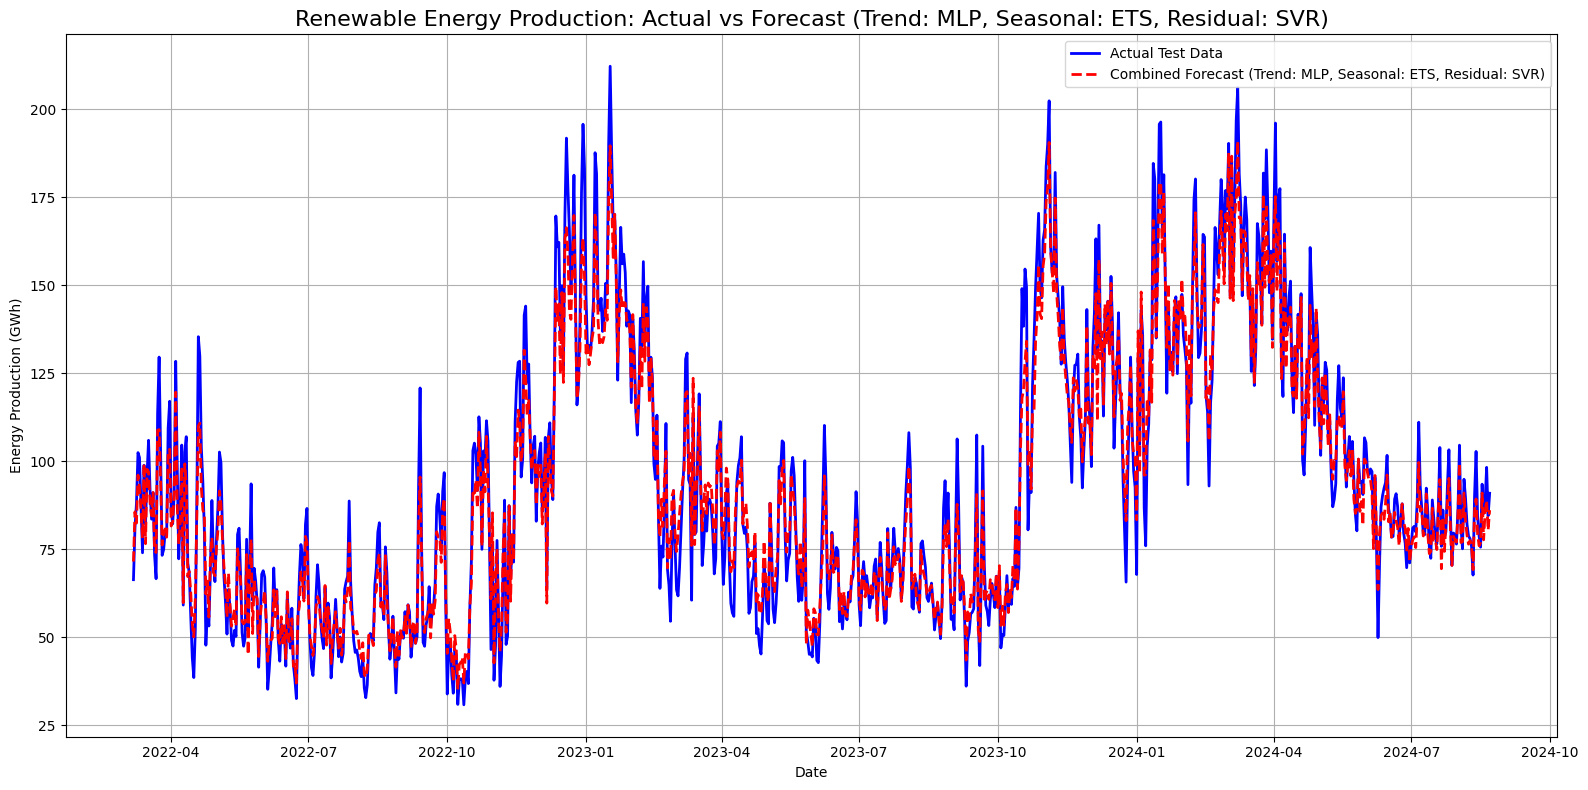


Forecast Accuracy Metrics for Trend: MLP, Seasonal: ETS, Residual: SVR:
MSE: 60.5660
RMSE: 7.7824
MAE: 5.8680
MAPE: 6.68%
R-squared: 0.9602


TypeError: object of type 'NoneType' has no len()

In [125]:
# Ensure indices align between actual test data and forecast
forecast_dates = trend_test.index[:steps_to_forecast]
actual_test_data = df_renewable.loc[forecast_dates]

# Define combinations of models for each component
trend_forecasts = [("MLP", trend_forecast_mlp), ("ETS", trend_forecast_Ets)]
seasonal_forecasts = [("ETS", seasonal_forecast)]
residual_forecasts = [("MLP", residual_forecast_mlp), ("SVR", residual_forecast_SVR)]

# Initialize a dictionary to store metrics for each combination
metrics = {}

# Iterate through all combinations of forecasts
for trend_name, trend_forecast in trend_forecasts:
    for seasonal_name, seasonal_forecast in seasonal_forecasts:
        for residual_name, residual_forecast in residual_forecasts:
            # Combine forecasts
            combined_forecast = np.zeros(steps_to_forecast)
            for t in range(steps_to_forecast):
                if t < len(trend_forecast) and t < len(seasonal_forecast) and t < len(residual_forecast):
                    combined_forecast[t] = trend_forecast[t] * seasonal_forecast[t] * residual_forecast[t]

            # Create a pandas Series with the forecast
            final_forecast = pd.Series(combined_forecast, index=forecast_dates)

            # Plot the results
            plt.figure(figsize=(16, 8))
            plt.plot(actual_test_data, 'b-', label='Actual Test Data', linewidth=2)
            plt.plot(final_forecast, 'r--', label=f'Combined Forecast (Trend: {trend_name}, Seasonal: {seasonal_name}, Residual: {residual_name})', linewidth=2)
            plt.title(f'Renewable Energy Production: Actual vs Forecast (Trend: {trend_name}, Seasonal: {seasonal_name}, Residual: {residual_name})', fontsize=16)
            plt.xlabel('Date')
            plt.ylabel('Energy Production (GWh)')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

            # Calculate forecast accuracy metrics
            # Align the lengths of actual_test_data and final_forecast
            actual_test_data_aligned = actual_test_data.iloc[:len(final_forecast)]
            mse = mean_squared_error(actual_test_data_aligned, final_forecast)
            rmse = np.sqrt(mse)
            mae = np.mean(np.abs(actual_test_data_aligned - final_forecast))

            # Avoid division by zero in MAPE calculation
            if (actual_test_data_aligned == 0).any():
                print("Warning: Division by zero encountered in MAPE calculation.")
                mape = np.nan
            else:
                mape = np.mean(np.abs((actual_test_data_aligned - final_forecast) / actual_test_data_aligned)) * 100

            # Calculate R-squared
            ss_total = np.sum((actual_test_data_aligned - actual_test_data_aligned.mean())**2)
            ss_residual = np.sum((actual_test_data_aligned - final_forecast)**2)
            r_squared = 1 - (ss_residual / ss_total)

            # Store metrics for this combination
            combination_name = f'Trend: {trend_name}, Seasonal: {seasonal_name}, Residual: {residual_name}'
            metrics[combination_name] = {
                'MSE': mse,
                'RMSE': rmse,
                'MAE': mae,
                'MAPE': mape,
                'R-squared': r_squared
            }

            # Print metrics
            print(f"\nForecast Accuracy Metrics for {combination_name}:")
            print(f"MSE: {mse:.4f}")
            print(f"RMSE: {rmse:.4f}")
            print(f"MAE: {mae:.4f}")
            print(f"MAPE: {mape:.2f}%")
            print(f"R-squared: {r_squared:.4f}")

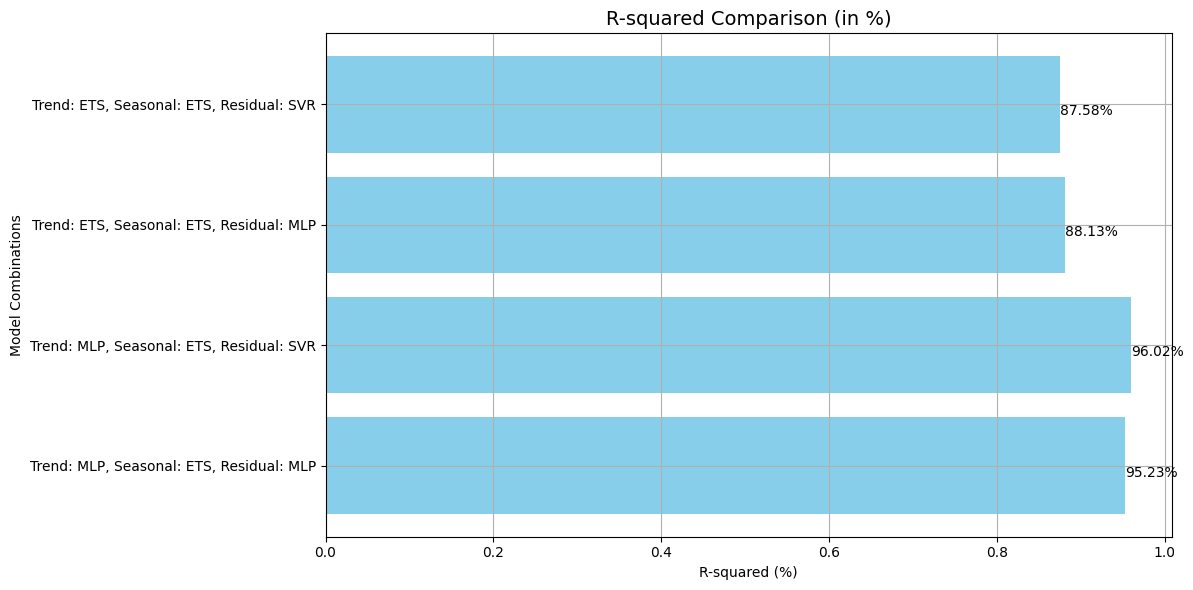

In [ ]:
# Extract R-squared values for each model combination
model_combinations = list(metrics.keys())
r_squared_values = [metrics[model]['R-squared'] for model in model_combinations]

# Create a bar plot for R-squared values
plt.figure(figsize=(12, 6))
plt.barh(model_combinations, r_squared_values, color='skyblue')

# Add percentage to the title
plt.title('R-squared Comparison (in %)', fontsize=14)
plt.xlabel('R-squared (%)')
plt.ylabel('Model Combinations')

# Convert R-squared values to percentages and display them on the bars
for i, v in enumerate(r_squared_values):
    plt.text(v, i, f"{v * 100:.2f}%", va='top', ha='left', fontsize=10, color='black')

plt.grid(True)
plt.tight_layout()
plt.show()


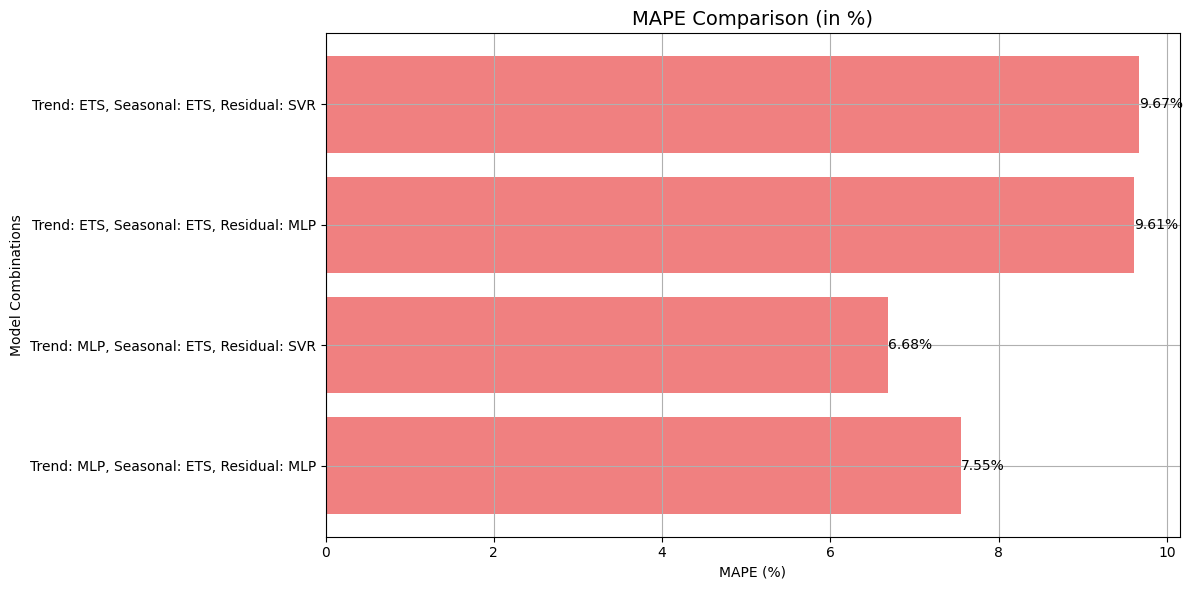

In [ ]:
# Extract MAPE values for each model combination
model_combinations = list(metrics.keys())
mape_values = [metrics[model]['MAPE'] for model in model_combinations]

# Create a bar plot for MAPE values
plt.figure(figsize=(12, 6))
plt.barh(model_combinations, mape_values, color='lightcoral')

# Add percentage to the title
plt.title('MAPE Comparison (in %)', fontsize=14)
plt.xlabel('MAPE (%)')
plt.ylabel('Model Combinations')

# Display MAPE values on the bars
for i, v in enumerate(mape_values):
    plt.text(v, i, f"{v:.2f}%", va='center', ha='left', fontsize=10, color='black')

plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
def train_and_tune_svr(df_train, df_test, n_lags=5):
    """
    Train and tune an SVR model using time-series cross-validation.

    Parameters:
        df_train (pd.Series): Training series.
        df_test (pd.Series): Testing series.
        n_lags (int): Number of lagged features to create.

    Returns:
        tuple: (best_model, best_params)
    """
    # Create lagged feature dataframe
    df_lagged = create_lagged_features(pd.concat([df_train, df_test]), n_lags=n_lags)

    # Train-test split (time-aware)
    split = int(len(df_lagged) * 0.8)
    train_df = df_lagged.iloc[:split]
    test_df = df_lagged.iloc[split:]

    X_train = train_df.drop(columns='y').values
    y_train = train_df['y'].values
    X_test = test_df.drop(columns='y').values
    y_test = test_df['y'].values

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Time series-aware cross-validation
    tscv = TimeSeriesSplit(n_splits=5)

    # Grid search over hyperparameters
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 0.01, 0.1, 1],
        'epsilon': [0.01, 0.1, 0.5],
        'kernel': ['rbf']
    }

    svr = SVR()
    grid_search = GridSearchCV(svr, param_grid, cv=tscv, scoring='r2', verbose=1, n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)

    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    print("Best Parameters:", best_params)

    # Optional: Evaluate performance on train set
    preds = best_model.predict(X_train_scaled)
    mse = mean_squared_error(y_train, preds)
    print("Train MSE with best model:", mse)

    return best_model, best_params

In [ ]:
best_model, best_params = train_and_tune_svr(residual_train,residual_test, n_lags=5)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters: {'C': 1, 'epsilon': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}
Train MSE with best model: 0.042052987278716786
